In [1]:
# packages

import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

from jax import grad, jit, vmap, jacfwd, jacrev, jvp, hessian

from numpy import random 

Code for solution of the Burgers equation 
\begin{equation*}
\begin{aligned}
& u_t+uu_x-(0.01/\pi)u_{xx}=f, x \in [-1,1], t \in [0,1]\\
& u(0,x)=\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}
where the ground truth is $u(t,x)=e^{-t^2}\sin(\pi x)$

In [2]:
# fix random seeds, for generating reference solution & sampled points
random.seed(20)

# we use x=(x1,x2) as (t,x)

# ground truth
def u(x1, x2):
    return jnp.exp(-x1**2)*jnp.sin(jnp.pi*x2)

# right hand side
def f(x1, x2):
    return grad(u,0)(x1,x2)+u(x1,x2)*grad(u,1)(x1,x2)-(0.01/jnp.pi)*grad(grad(u,1),1)(x1,x2)

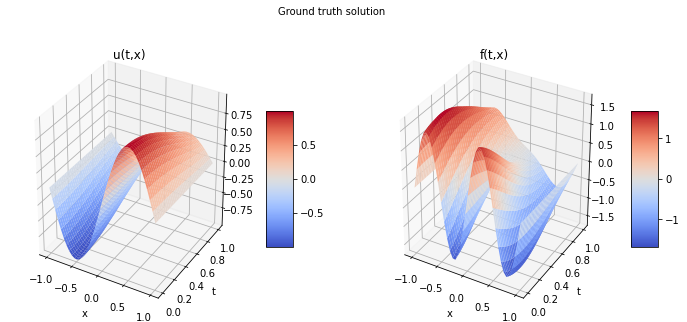

In [3]:
# plot the solution u(x,y)

# define the function
def plot_u_f(num_pts):
    xx = onp.linspace(0, 1, num_pts)
    yy = onp.linspace(-1, 1, num_pts)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())

    ZZ_u = onp.vectorize(u)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts,num_pts)

    ZZ_f = vmap(lambda x1, x2: f(x1, x2))(XXv, YYv)
    ZZ_f = ZZ_f.reshape(num_pts,num_pts)

    # plot figures
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Ground truth solution', fontsize=10)
    #===============
    #  First subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_surface(YY, XX, ZZ_u, cmap=plt.cm.coolwarm)
    fig.colorbar(surf, shrink= 0.5, aspect = 5)
    ax.set_title('u(t,x)')
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    #===============
    # Second subplot
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax.plot_surface(YY, XX, ZZ_f, cmap=plt.cm.coolwarm)
    fig.colorbar(surf2, shrink= 0.5, aspect = 5)
    ax.set_title('f(t,x)')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    plt.show()

# plot the figure
plot_u_f(40)

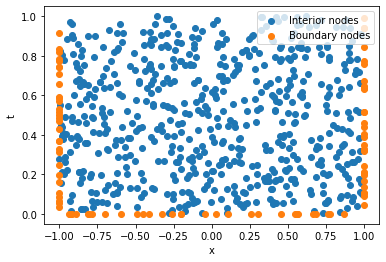

In [5]:
# sampled points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0, 1.0, (N_domain, 2))
    X_domain[:,1] = 2*X_domain[:,1]-1
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[:int(N_boundary/3), 1] = random.uniform(-1.0, 1.0, int(N_boundary/3))
    # right face
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[int(N_boundary/3):2*int(N_boundary/3), 1] = 1
    # left face
    X_boundary[2*int(N_boundary/3):, 0] = random.uniform(0.0, 1.0, int(N_boundary/3))
    X_boundary[2*int(N_boundary/3):, 1] = -1

    fig, ax = plt.subplots()
    ax.scatter(X_domain[range(N_domain), 1], X_domain[range(N_domain), 0], label='Interior nodes')
    ax.scatter(X_boundary[range(N_boundary), 1], X_boundary[range(N_boundary), 0], label='Boundary nodes')
    ax.legend(loc="upper right")
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    plt.show()
    return X_domain, X_boundary

N_domain = 600
N_boundary = 90
X_domain, X_boundary = sample_points(N_domain, N_boundary)

In [6]:
# Define a real valued kernel kappa(x, y; sigma) \to R
def kappa(x1, x2, y1, y2, sigma= 0.2):
    # x,y are 2D input row vectors
    # sigma is the variance parameter
    return jnp.exp(-(1/(2*sigma**2))*( (x1- y1)**2 + (x2 - y2)**2 ))


def D_x1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,1)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),1)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),2)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,0),3),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,1),3)(x1, x2, y1, y2, sigma)
    return val

def D_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(kappa,1),3),3)(x1, x2, y1, y2, sigma)
    return val

def DD_x2_DD_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(grad(grad(kappa,1),1),3),3)(x1, x2, y1, y2, sigma)
    return val

# Hessian vector product from JAX documentation
def hvp(f, primals, tangents):
    return jvp(grad(f), primals, tangents)[1]

We organize all the variables in the way: $[v_1,v_2,v_3,v_0,v_b]$, where $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively; and $v_b$ is the boundary value. 

The Gram matrix $\Theta$ is then determined by this organization. Next code block is to construct this matrix.


In [7]:
# setup model parameters
set_sigma = 0.2
set_nugget = 1e-3

# vectorized construction of the Gram matrix Theta
def assembly_Theta():
    Theta = onp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior v.s. interior interaction (used for construct kernel matrix)
    XXdd0=onp.transpose(onp.tile(Xd0,(N_domain,1)))
    XXdd1=onp.transpose(onp.tile(Xd1,(N_domain,1)))

    # interior+boudary v.s. interior+bpundary interaction
    XXdbdb0=onp.transpose(onp.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=onp.transpose(onp.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary interaction
    XXddb0=onp.transpose(onp.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=onp.transpose(onp.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=onp.tile(Xdb0,(N_domain,1))
    XXddb1_2=onp.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior 
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[0:N_domain, 0:N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[0:N_domain, N_domain:2*N_domain] =  onp.reshape(val, (N_domain, N_domain))
    Theta[N_domain:2*N_domain, 0:N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x1_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[0:N_domain, 2*N_domain:3*N_domain] =  -onp.reshape(val, (N_domain, N_domain))
    Theta[2*N_domain:3*N_domain, 0:N_domain] =  -onp.transpose(onp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[N_domain:2*N_domain, N_domain:2*N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[N_domain:2*N_domain, 2*N_domain:3*N_domain] =  -onp.reshape(val, (N_domain, N_domain))
    Theta[2*N_domain:3*N_domain, N_domain:2*N_domain] =  -onp.transpose(onp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_DD_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),onp.transpose(XXdbdb0).flatten(),onp.transpose(XXdbdb1).flatten())
    Theta[3*N_domain:, 3*N_domain:] =  onp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary))

    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: D_x1_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[0:N_domain, 3*N_domain:] = -onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[3*N_domain:, 0:N_domain] = -onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[N_domain:2*N_domain, 3*N_domain:] = -onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[3*N_domain:, N_domain:2*N_domain] = -onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    val = vmap(lambda x1, x2, y1, y2: DD_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[2*N_domain:3*N_domain, 3*N_domain:] = onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[3*N_domain:, 2*N_domain:3*N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    # calculate trace
    trace1 = onp.trace(Theta[:N_domain, :N_domain])
    trace2 = onp.trace(Theta[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3 = onp.trace(Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4 = onp.trace(Theta[3*N_domain:, 3*N_domain:])
    ratio = [trace1/trace4, trace2/trace4, trace3/trace4]
    return Theta, ratio

Theta, ratio = assembly_Theta()

We add nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda_1 I & 0 & 0 & 0\\
0 & \lambda_2 I & 0 & 0\\
0 & 0 & \lambda_3I & 0 \\
0 & 0 & 0 & I
\end{bmatrix}
\end{equation*}
where $\lambda_1, \lambda_2, \lambda_3$ are selected to be the trace ratios of the orginal Gram matrix

In [8]:
print('trace ratio =', ratio)

# add nugget term
temp=onp.concatenate((ratio[0]*onp.ones((1,N_domain)), ratio[1]*onp.ones((1,N_domain)), ratio[2]*onp.ones((1,N_domain)), onp.ones((1,N_domain+N_boundary))), axis=1)



Theta = Theta + set_nugget*onp.diag(temp[0]) 

# another choice 1 of regularization:
# temp=onp.concatenate((sum(ratio)*onp.ones((1,3*N_domain)), onp.ones((1,N_domain+N_boundary))), axis=1)
# Theta = Theta + set_nugget*onp.diag(temp[0]) 

# another choice 2 of regularization:
# Theta = Theta + set_nugget*onp.identity(4*N_domain + N_boundary)

# print out the condition number and sparsity pattern
# print('Regularized Theta cond=', onp.linalg.cond(Theta))
# plt.matshow(Theta)

trace ratio = [21.73913043478261, 21.73913043478261, 1630.4347826086957]


Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v_1,v_2,v_3,v_0,v_b]\Theta_{\lambda}^{-1} [v_1,v_2,v_3,v_0,v_b]^T\\
  \text{s.t.}&\quad v_1+v_0v_2-(0.01/\pi)v_3=f, \text{ and } v_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v_0, v_1, v_2, v_3$ represent the interior nodal values of $u(x_i), u_t(x_i), u_x(x_i), u_{xx}(x_i)$, respectively.

iter =  0  J =  699720.44
iter =  100 GD step size = 0.5  J =  19159.793
iter =  200 GD step size = 0.5  J =  18020.617
iter =  300 GD step size = 0.5  J =  17510.35
iter =  400 GD step size = 0.5  J =  17062.025
iter =  500 GD step size = 0.5  J =  16660.133
iter =  600 GD step size = 0.5  J =  16298.378
iter =  700 GD step size = 0.5  J =  15971.627
iter =  800 GD step size = 0.5  J =  15675.462
iter =  900 GD step size = 0.5  J =  15406.237
iter =  1000 GD step size = 0.5  J =  15160.681
iter =  1100 GD step size = 0.5  J =  14936.389
iter =  1200 GD step size = 0.5  J =  14732.455
iter =  1300 GD step size = 0.5  J =  14545.194
iter =  1400 GD step size = 0.5  J =  14372.946
iter =  1500 GD step size = 0.5  J =  14214.143
iter =  1600 GD step size = 0.5  J =  14067.435
iter =  1700 GD step size = 0.5  J =  13931.558
iter =  1800 GD step size = 0.5  J =  13805.461
iter =  1900 GD step size = 0.5  J =  13688.155
iter =  2000 GD step size = 0.5  J =  13578.786
iter =  2100 GD step siz

Text(0.5, 1.0, 'Loss function history')

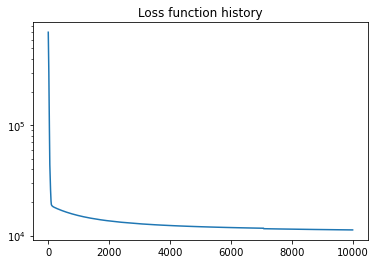

In [15]:
L = onp.linalg.cholesky(Theta)

# construct data vectors
fy = vmap(lambda x1, x2: f(x1, x2))(X_domain[:,0], X_domain[:,1])  # rhs data
gy = onp.vectorize(u)(X_boundary[:,0], X_boundary[:,1]) # boundary data

# define cost function
def J(v):
    v0 = v[:N_domain]
    v2 = v[N_domain:2*N_domain]
    v3 = v[2*N_domain:]
    vv = jnp.concatenate(((0.01/jnp.pi)*v3+fy-v0*v2, v2, v3, v0, gy), axis=0)
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

grad_J = grad(J)
Hessian_J = jacfwd(jacrev(J))

# initial guess
sol = random.normal(0, 1.0, (3*N_domain))
J_hist = []
max_iter = 1e+4
J_hist.append(J(sol))
iter_step = 0
print('iter = ', iter_step, ' J = ', J(sol))

# ============== optimization ================

# Method: Newton's method with line search
# while iter_step < max_iter:
#     step_size = 1
#     temp = jnp.linalg.solve(Hessian_J(sol), grad_J(sol))
#     sol_temp = sol - step_size*temp
#     J_now = J(sol_temp)
#     while J_now>J_hist[-1]:
#         step_size /= 2
#         sol_temp = sol - step_size*temp
#         J_now = J(sol_temp)
#     sol = sol_temp
#     J_hist.append(J_now)
#     iter_step += 1
#     print('iter = ', iter_step, 'Newton step size =', step_size, ' J = ', J(sol))
#     if step_size < 1e-7:
#         break
#     if abs(J_hist[-1]-J_hist[-2]) < 1e-4:
#         break
        
# Method: GD with line search
while iter_step < max_iter:
    step_size = 0.5
    temp = grad_J(sol)/onp.linalg.norm(grad_J(sol))
    sol_temp = sol - step_size*temp
    J_now = J(sol_temp)
    while J_now>J_hist[-1]:
        step_size /= 2
        sol_temp = sol - step_size*temp
        J_now = J(sol_temp)
    sol = sol_temp
    J_hist.append(J_now)
    iter_step += 1
    if iter_step % 100 == 0:
        print('iter = ', iter_step, 'GD step size =', step_size, ' J = ', J(sol))
    if step_size < 1e-9:
        break
    if abs(J_hist[-1]-J_hist[-2]) < 1e-4:
        break

# Method: Hybrid Newton + GD
# while iter_step < max_iter:
#     step_size = 1
#     gradient_direc = grad_J(sol)
#     Newton_direc = jnp.linalg.solve(Hessian_J(sol), gradient_direc)
#     sol_temp = sol - step_size*Newton_direc
#     iter_step += 1
#     if J(sol_temp)<J(sol):
#         sol = sol_temp
#         J_hist.append(J(sol))
#         print('iter = ', iter_step, 'Newton step size =', step_size, ' J = ', J(sol))
#     else:
#         sol = sol - step_size*gradient_direc/onp.linalg.norm(gradient_direc)
#         J_hist.append(J(sol))
#         print('iter = ', iter_step, 'GD step size =', step_size, ' J = ', J(sol))
#     if abs(J_hist[-1]-J_hist[-2]) < 1e-4:
#         break

# Method: regularized Newton (add identity to Hessian)
# while iter_step < max_iter:
#     step_size = 1
#     gradient_direc = grad_J(sol)
#     Newton_direc = jnp.linalg.solve(Hessian_J(sol)+onp.identity(3*N_domain), gradient_direc)
#     sol = sol - step_size*Newton_direc
#     iter_step += 1
#     print('iter = ', iter_step, 'Newton step size =', step_size, ' J = ', J(sol))
#     J_hist.append(J(sol))
    
plt.plot(onp.arange(iter_step+1),J_hist)
plt.yscale("log")
plt.title('Loss function history')

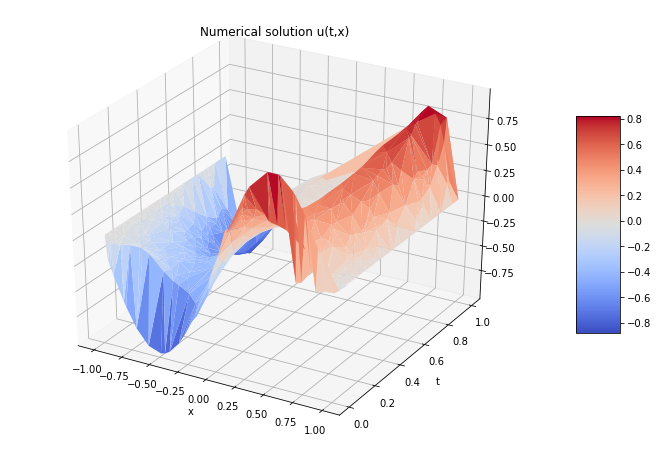

should compare with the ground truth solution:


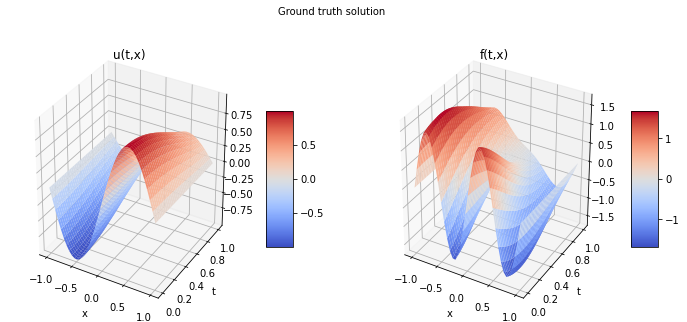

In [16]:
# scatter plot of solution at collocation nodes 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
uu = onp.append(sol[:N_domain], gy)
X_1_vals = onp.append(X_domain[range(N_domain), 0], X_boundary[range(N_boundary), 0])
X_2_vals = onp.append(X_domain[range(N_domain), 1], X_boundary[range(N_boundary), 1])
u_surf=ax.plot_trisurf(X_2_vals, X_1_vals, uu, cmap=plt.cm.coolwarm)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Numerical solution u(t,x)')

fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
plt.show()
print("should compare with the ground truth solution:")
plot_u_f(40)